In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


# pip install torchsummary
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset


# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset
from eval import *

# speed-up using multithreads!
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

In [2]:
# fig,ax = plt.subplots(1,3, figsize=(12,6))
# for i, ind in enumerate([0,1,9]):

#     ax[i].imshow(images[ind].permute(1,2,0))
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])

#     # Show annotations
#     for ann in bboxes[ind]:
#         [x, y, x1, y1] = ann
#         rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
#                          facecolor='none', alpha=0.7)
#         ax[i].add_patch(rect)
#     #plt.savefig(f'imgs/output_{img_idx}.png')
# plt.tight_layout()
# plt.show()

In [3]:
img_size = 512

train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
)

test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco',
                            label_fields=['labels'],
                           )
)

BATCH_SIZE = 32

In [4]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12, collate_fn=lambda x: x)# persistent_workers=True, pin_memory=True)

In [5]:
loss_function = nn.BCELoss()

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = transfer_model_set(model, freeze_convs=False)
optimizer = torch.optim.Adam(model.parameters(), HEAD_LEARNING_RATE)

lr_scheduler = None

In [6]:
def denormalize(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    denormalize = transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                         std=[1/0.229, 1/0.224, 1/0.225])

    denorm_image = denormalize(img)
    x = ((denorm_image - denorm_image.min())/(denorm_image - denorm_image.min()).max() * 255).to(torch.int64)
    return x

In [7]:
def edge_boxes_train(images: list, bboxes: list, k: float = 0.5, p: float = 0.01, img_size: int = 150):
    """
    Takes lists of images and bboxes and returns proposals, cropped images and predictions.
    """
    proposals_all = []
    proposals_filtered_all = []
    predictions_all = []
    cropped_images_all = []
    for image, img_bboxes in zip(images, bboxes):
        
        image_denorm = denormalize(image)
        proposals = edge_boxes(image_denorm.permute([1,2,0]).numpy())
        proposals_all.append(proposals)
        ## proposals = selective_search(image.permute([1,2,0]).numpy())
        proposals_img = []
        cropped_images = []
        predictions = []
        # IoU
        for proposal in proposals:
            scores_all = []
            
            t1 = time.time() 
            for bbox in img_bboxes:
                score = calculate_iou(proposal, bbox)
                scores_all.append(score)
            
            prediction = max(scores_all) > k # Binary classification
            x, y, w, h = proposal
            
            # Extract image
            if prediction or random.random() < p:
                cropped_image = image_denorm[:, y:y+h, x:x+w]
                resized_image = fn.resize(cropped_image, size=[img_size, img_size])

                cropped_images.append(resized_image)
                predictions.append(prediction)
                proposals_img.append(proposal.tolist())
                
        proposals_filtered_all.append(proposals_img)
        cropped_images_all.append(cropped_images)
        predictions_all.append(predictions)
        
    return images, proposals_all, proposals_filtered_all, cropped_images_all, predictions_all


In [8]:
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    model.train()
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")

    train_loss = []
    train_correct = 0
    train_len = 0
    
    for minibatch_no, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        images = [image for image, _, _ in batch]
        bboxes = [bbox for _, bbox, _ in batch]
        labels = [label for _, _, label in batch]
        
        # Selective search
                
        # Edge boxes
        images, proposals_all, proposals_filtered_all, cropped_images_all, predictions_all = edge_boxes_train(images, bboxes) 
        break

EPOCH 0/1


  0%|          | 0/29 [00:00<?, ?it/s]

/zhome/3d/d/152828/course02514/env/dlcv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
for i in range(BATCH_SIZE):
    if min(len(proposals_all[i]), len(proposals_filtered_all[i])) !=0: 
        print('Ind: ', i, 'Lens: ', len(proposals_all[i]), len(proposals_filtered_all[i]) )

Ind:  0 Lens:  2000 38
Ind:  1 Lens:  394 12
Ind:  2 Lens:  2000 24
Ind:  3 Lens:  2000 48
Ind:  4 Lens:  2000 22
Ind:  5 Lens:  2000 34
Ind:  6 Lens:  1542 29
Ind:  7 Lens:  1183 27
Ind:  8 Lens:  163 12
Ind:  9 Lens:  895 29
Ind:  10 Lens:  2000 25
Ind:  11 Lens:  868 24
Ind:  12 Lens:  1604 26
Ind:  13 Lens:  1243 63
Ind:  14 Lens:  2000 28
Ind:  15 Lens:  2000 37
Ind:  16 Lens:  1740 15
Ind:  17 Lens:  2000 41
Ind:  18 Lens:  776 5
Ind:  19 Lens:  2000 26
Ind:  20 Lens:  1118 51
Ind:  21 Lens:  2000 52
Ind:  22 Lens:  2000 42
Ind:  23 Lens:  2000 20
Ind:  24 Lens:  383 20
Ind:  25 Lens:  2000 45
Ind:  26 Lens:  1164 18
Ind:  27 Lens:  2000 32
Ind:  28 Lens:  271 18
Ind:  29 Lens:  2000 48
Ind:  30 Lens:  2000 38


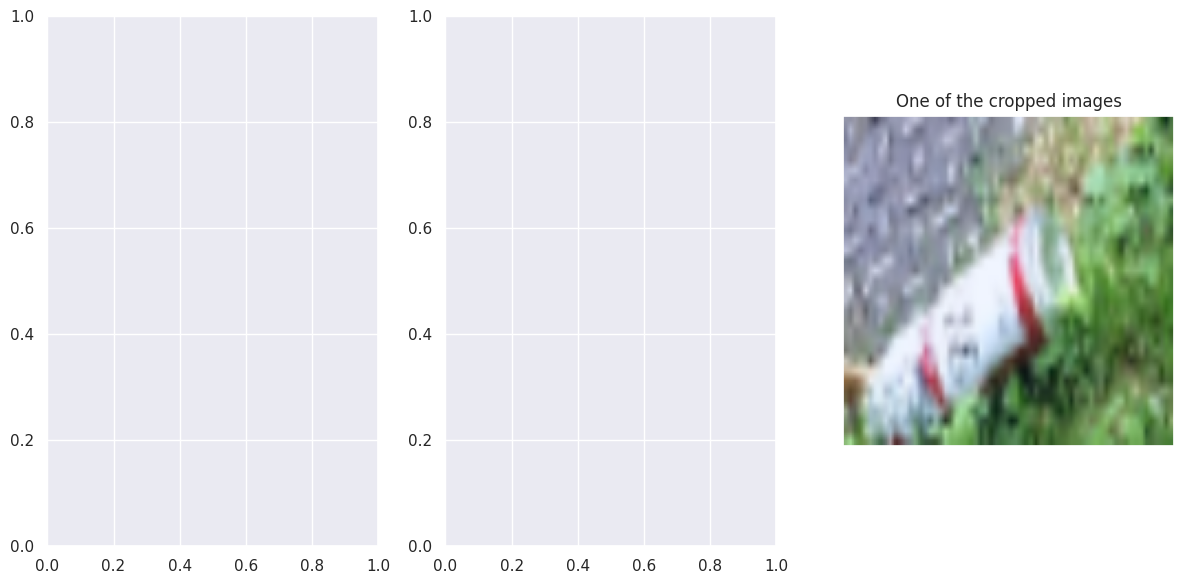

In [11]:
fig,ax = plt.subplots(1,3, figsize=(12,6))
ind = 12
ax[2].imshow(cropped_images_all[ind][16].permute(1,2,0))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('One of the cropped images')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


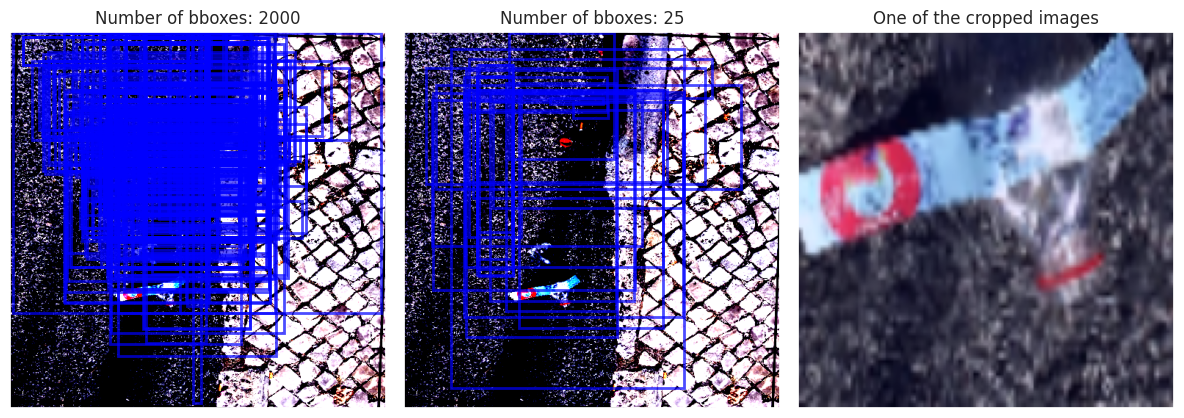

In [23]:
fig,ax = plt.subplots(1,3, figsize=(12,6))
ind = 10

ax[0].imshow(images[ind].permute(1,2,0))
ax[0].set_xticks([])
ax[0].set_yticks([])

# Show annotations
for ann in proposals_all[ind][:200]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
                     facecolor='none', alpha=0.7)
    ax[0].add_patch(rect)
    #plt.savefig(f'imgs/output_{img_idx}.png')
ax[0].set_title('Number of bboxes: '+str(len(proposals_all[ind])))

ax[1].imshow(images[ind].permute(1,2,0))
ax[1].set_xticks([])
ax[1].set_yticks([])

# Show annotations
for ann in proposals_filtered_all[ind]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
                     facecolor='none', alpha=0.7)
    ax[1].add_patch(rect)
ax[1].set_title('Number of bboxes: '+str(len(proposals_filtered_all[ind])))


ax[2].imshow(cropped_images_all[ind][10].permute(1,2,0))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('One of the cropped images')

plt.tight_layout()
plt.show()

In [20]:
fig,ax = plt.subplots(1,3, figsize=(12,6))
ind = 12

ax[0].imshow(images[ind].permute(1,2,0))
ax[0].set_xticks([])
ax[0].set_yticks([])

# Show annotations
for ann in proposals_all[ind][:200]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
                     facecolor='none', alpha=0.7)
    ax[0].add_patch(rect)
    #plt.savefig(f'imgs/output_{img_idx}.png')
ax[0].set_title('Number of bboxes: '+str(len(proposals_all[ind])))

ax[1].imshow(images[ind].permute(1,2,0))
ax[1].set_xticks([])
ax[1].set_yticks([])

# Show annotations
for ann in proposals_filtered_all[ind]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
                     facecolor='none', alpha=0.7)
    ax[1].add_patch(rect)
ax[1].set_title('Number of bboxes: '+str(len(proposals_filtered_all[ind])))


ax[2].imshow(cropped_images_all[ind][15].permute(1,2,0))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('One of the cropped images')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 600x600 with 0 Axes>

In [14]:
fig,ax = plt.subplots(1,3, figsize=(12,6))
ind = 13

ax[0].imshow(images[ind].permute(1,2,0))
ax[0].set_xticks([])
ax[0].set_yticks([])

# Show annotations
for ann in proposals_all[ind]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
                     facecolor='none', alpha=0.7)
    ax[0].add_patch(rect)
    #plt.savefig(f'imgs/output_{img_idx}.png')


ax[1].imshow(image.permute(1,2,0))
ax[1].set_xticks([])
ax[1].set_yticks([])

# Show annotations
for ann in proposals_filtered_all[ind]:
    [x, y, x1, y1] = ann
    rect = Rectangle((x,y),x1-x,y1-y,linewidth=2,edgecolor='blue',
                     facecolor='none', alpha=0.7)
    ax[1].add_patch(rect)
    
plt.tight_layout()
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3e13723a0>
Traceback (most recent call last):
  File "/zhome/3d/d/152828/course02514/env/dlcv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/zhome/3d/d/152828/course02514/env/dlcv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/appl/python/3.8.2/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/appl/python/3.8.2/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/appl/python/3.8.2/lib/python3.8/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
  File "/appl/python/3.8.2/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInte

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff3addc4c10> (for post_execute):



KeyboardInterrupt



In [ ]:
def edge_boxes(model, img, max_boxes: int, alpha = None, beta = None):
    eb = cv2.ximgproc.createEdgeBoxes()
    
    # rgb_im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    edges = model.detectEdges(np.float32(img) / 255.0)

    orimap = model.computeOrientation(edges)
    edges = model.edgesNms(edges, orimap)

    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_boxes)
#     edge_boxes.setAlpha(alpha)
#     edge_boxes.setBeta(beta)
    boxes, _ = edge_boxes.getBoundingBoxes(edges, orimap)
    return boxes

In [ ]:
# edge boxes
edge_detection = cv2.ximgproc.createStructuredEdgeDetection('model.yml.gz')

train_proposals = []
for (img, _, _) in tqdm(trainset):
    proposals, scores = edge_boxes(edge_detection, img.permute([1,2,0]).numpy(), 1000)
    train_proposals.append(proposals)